## 1. Loading Data

In this step, we import the core Python libraries and load the two datasets used in the project:

- **rental_listing.csv** → Contains apartment rental listings in Istanbul.
- **istanbul_earthquake.csv** → Contains neighborhood-level earthquake loss estimations from İBB.

The rental dataset is at the *listing level* (each row = one apartment), while the earthquake dataset is at the *district/neighborhood level*.

Both files use `;` as a separator, so we specify `sep=";"` when reading them.

After loading, we print their shapes to confirm that the files were read correctly and inspect basic structure.

In [15]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rental_path = "../data/rental_listing.csv"
eq_path = "../data/istanbul_earthquake.csv"

#loading datasets
rental_raw = pd.read_csv(rental_path, sep=";")
eq_raw = pd.read_csv(eq_path, sep=";")

print(rental_raw.shape)
print(eq_raw.shape)

(11627, 8)
(970, 10)


## 2. Cleaning location fields and merging datasets

Before merging the rental and earthquake datasets, we need district and neighborhood names to be written in a consistent format.

In this step we:

1. Make a copy of both raw DataFrames (`rent_df_clean`, `eq_df_clean`).
2. Rename rental columns for easier use:
   - `living room` → `living_room`
   - `area (m2)` → `area_m2`
   - `price` → `price_per_m2` (rent per m² in TRY)
3. Define helper functions to:
   - Normalize Turkish characters (ç, ğ, ı, ö, ş, ü → c, g, i, o, s, u)
   - Strip suffixes like `"Mahallesi"`, `"Mah."`, `"mah"` from neighborhood names in the rental dataset
   - Lowercase and remove simple formatting differences
4. Apply these functions to both datasets so that `district` and `neighborhood` become directly comparable.
5. Fix a specific naming mismatch (`eyupsultan` → `eyup`) that appears differently across sources.
6. Fill missing values in `minor_injury` with 0 in the earthquake data.
7. Perform an **inner join** on `["district", "neighborhood"]` to obtain one combined table of rental listings enriched with earthquake risk information.
8. Compute an additional convenience variable `total_rent = price_per_m2 * area_m2` (total monthly rent).

This merged DataFrame will be the main working dataset used in the EDA and hypothesis testing sections.

In [ ]:

rent_df_clean = rental_raw.copy()
eq_df_clean   = eq_raw.copy()

#renaming columns for consistency
rent_df_clean = rent_df_clean.rename(columns={
    "living room": "living_room",
    "area (m2)": "area_m2",
    "price": "price_per_m2"
})

#standardizing district and neighborhood names
def normalize_tr(s):
    if not isinstance(s, str):
        return ""
    s = s.strip()
    repl = {
        "ç":"c","Ç":"c",
        "ğ":"g","Ğ":"g",
        "ı":"i","I":"i",
        "İ":"i",
        "ö":"o","Ö":"o",
        "ş":"s","Ş":"s",
        "ü":"u","Ü":"u"
    }
    for k,v in repl.items():
        s = s.replace(k,v)
    return s.lower()

def clean_district(name):
    return normalize_tr(name)

def clean_neighborhood_rental(name):
    if not isinstance(name, str):
        return ""
    s = name.strip()
    endings = [" Mahallesi", " Mah.", " Mah", " mahallesi", " mah.", " mah"]
    for token in endings:
        if s.endswith(token):
            s = s[:-len(token)]
            break
    s = s.replace(".", "")
    return normalize_tr(s)

def clean_neighborhood_eq(name):
    if not isinstance(name, str):
        return ""
    return normalize_tr(name.strip())

rent_df_clean["district"]    = rent_df_clean["district"].apply(clean_district)
rent_df_clean["neighborhood"] = rent_df_clean["neighborhood"].apply(clean_neighborhood_rental)
rent_df_clean["district"]    = rent_df_clean["district"].replace({"eyupsultan": "eyup"})

eq_df_clean["district"]    = eq_df_clean["district"].apply(clean_district)
eq_df_clean["neighborhood"] = eq_df_clean["neighborhood"].apply(clean_neighborhood_eq)

eq_df_clean["minor_injury"] = eq_df_clean["minor_injury"].fillna(0)

#merging the two cleaned datasets on standardized district & neighborhood
merged_df = pd.merge(
    rent_df_clean,
    eq_df_clean,
    on=["district", "neighborhood"],
    how="inner"
)
merged_df["total_rent"] = merged_df["price_per_m2"] * merged_df["area_m2"]

print(merged_df.shape)
merged_df.head()

(11177, 17)


,district,neighborhood,room,living_room,area_m2,age,floor,price_per_m2,very_heavy_damage,heavy_damage,moderate_damage,light_damage,fatality,severe_injury,hospital_treated,minor_injury,total_rent
0,bakirkoy,kartaltepe,2,1,90,45,3,260,82,132,393,567,166,89,424,725.0,23400
1,cekmekoy,merkez,3,1,150,11,0,850,1,13,113,364,0,0,0,8.0,127500
2,fatih,mevlanakapi,2,1,68,35,1,130,80,124,330,457,84,54,218,375.0,8840
3,bahcelievler,bahcelievler,2,1,90,1,-2,400,81,147,488,752,185,99,480,838.0,36000
4,fatih,seyyid omer,1,1,65,42,1,165,77,119,236,407,91,54,236,407.0,10725


## 3. Creating Earthquake Risk Indicators

To compare earthquake exposure across neighborhoods, we construct three key indicators:

1. **Damage Ratio**  
   - Severe damage proportion = (Heavy + Very Heavy Damage) / Total Buildings  
   - Represents structural vulnerability.

2. **Casualty Ratio**  
   - Severe casualties proportion = (Fatalities + Severe Injuries) / Total Buildings  
   - Captures life-threatening impact.

3. **Earthquake Risk Index**  
   - A combined, normalized metric that averages damage and casualty severity.  
   - Scaled between 0 and 1 for comparability.

These engineered features allow us to quantitatively test the relationship between earthquake risk and rental prices.

In [20]:
merged_df["total_buildings"] = (
    merged_df["light_damage"]
    + merged_df["moderate_damage"]
    + merged_df["heavy_damage"]
    + merged_df["very_heavy_damage"]
)

#computing damage ratio and casualty ratio
merged_df["damage_ratio"] = (
    (merged_df["heavy_damage"] + merged_df["very_heavy_damage"])
    / merged_df["total_buildings"]
)

merged_df["casualty_ratio"] = (
    (merged_df["fatality"] + merged_df["severe_injury"])
    / merged_df["total_buildings"]
)

#normalizing damage_ratio and casualty_ratio
dmin = merged_df["damage_ratio"].min()
dmax = merged_df["damage_ratio"].max()
merged_df["damage_norm"] = (merged_df["damage_ratio"] - dmin) / (dmax - dmin)

cmin = merged_df["casualty_ratio"].min()
cmax = merged_df["casualty_ratio"].max()
merged_df["casualty_norm"] = (merged_df["casualty_ratio"] - cmin) / (cmax - cmin)

#computing earthquake risk index as average of normalized damage and casualty ratios
merged_df["earthquake_risk_index"] = (
    merged_df["damage_norm"] + merged_df["casualty_norm"]
) / 2

merged_df.head()

,district,neighborhood,room,living_room,area_m2,age,floor,price_per_m2,very_heavy_damage,heavy_damage,moderate_damage,light_damage,fatality,severe_injury,hospital_treated,minor_injury,total_rent,total_buildings,damage_ratio,casualty_ratio,damage_norm,casualty_norm,earthquake_risk_index
0,bakirkoy,kartaltepe,2,1,90,45,3,260,82,132,393,567,166,89,424,725.0,23400,1174,0.182283,0.217206,0.400821,0.378022,0.389421
1,cekmekoy,merkez,3,1,150,11,0,850,1,13,113,364,0,0,0,8.0,127500,491,0.028513,0.000000,0.062698,0.000000,0.031349
2,fatih,mevlanakapi,2,1,68,35,1,130,80,124,330,457,84,54,218,375.0,8840,991,0.205853,0.139253,0.452648,0.242354,0.347501
3,bahcelievler,bahcelievler,2,1,90,1,-2,400,81,147,488,752,185,99,480,838.0,36000,1468,0.155313,0.193460,0.341518,0.336696,0.339107
4,fatih,seyyid omer,1,1,65,42,1,165,77,119,236,407,91,54,236,407.0,10725,839,0.233611,0.172825,0.513687,0.300782,0.407234


## 4. Exploratory Data Analysis (EDA)

Before testing the hypotheses, we explore the merged dataset to understand the 
distribution of rental prices, earthquake risk variables, and building characteristics. 

This section covers:
- Dataset structure
- Summary statistics
- Missing-value checks
- Distributions of key variables
- Correlation analysis

In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11177 entries, 0 to 11176
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district               11177 non-null  object 
 1   neighborhood           11177 non-null  object 
 2   room                   11177 non-null  int64  
 3   living_room            11177 non-null  int64  
 4   area_m2                11177 non-null  int64  
 5   age                    11177 non-null  int64  
 6   floor                  11177 non-null  int64  
 7   price_per_m2           11177 non-null  int64  
 8   very_heavy_damage      11177 non-null  int64  
 9   heavy_damage           11177 non-null  int64  
 10  moderate_damage        11177 non-null  int64  
 11  light_damage           11177 non-null  int64  
 12  fatality               11177 non-null  int64  
 13  severe_injury          11177 non-null  int64  
 14  hospital_treated       11177 non-null  int64  
 15  mi

### 4.1 Summary Statistics
We compute key descriptive statistics to understand the spread of rental price, 
earthquake risk, and structural features.

In [22]:
merged_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
district,11177,38,sisli,1189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood,11177,549,maslak,343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room,11177.0,NaN,NaN,NaN,2.292744,2.169701,1.0,2.0,2.0,3.0,180.0
living_room,11177.0,NaN,NaN,NaN,1.182249,10.226347,0.0,1.0,1.0,1.0,965.0
area_m2,11177.0,NaN,NaN,NaN,140.717634,1688.951462,6.0,80.0,100.0,140.0,178158.0
age,11177.0,NaN,NaN,NaN,17.737318,23.569098,0.0,5.0,15.0,29.0,1864.0
floor,11177.0,NaN,NaN,NaN,3.874116,4.791351,-3.0,1.0,2.0,4.0,21.0
price_per_m2,11177.0,NaN,NaN,NaN,45098.133936,275243.501453,40.0,1500.0,22000.0,40000.0,23000000.0
very_heavy_damage,11177.0,NaN,NaN,NaN,19.373445,29.679394,0.0,2.0,5.0,22.0,201.0
heavy_damage,11177.0,NaN,NaN,NaN,45.320658,57.314847,0.0,8.0,20.0,62.0,313.0


### 4.2 Missing Value Analysis
We verify whether any critical variables still contain missing data.

In [23]:
merged_df.isna().sum()

district                 0
neighborhood             0
room                     0
living_room              0
area_m2                  0
age                      0
floor                    0
price_per_m2             0
very_heavy_damage        0
heavy_damage             0
moderate_damage          0
light_damage             0
fatality                 0
severe_injury            0
hospital_treated         0
minor_injury             0
total_rent               0
total_buildings          0
damage_ratio             0
casualty_ratio           0
damage_norm              0
casualty_norm            0
earthquake_risk_index    0
dtype: int64

### 4.3 Distribution of Rent Price per m²

The distribution is right-skewed, meaning a small number of luxury listings 
increase the upper tail. This justifies using both raw plots and log-scaled plots.

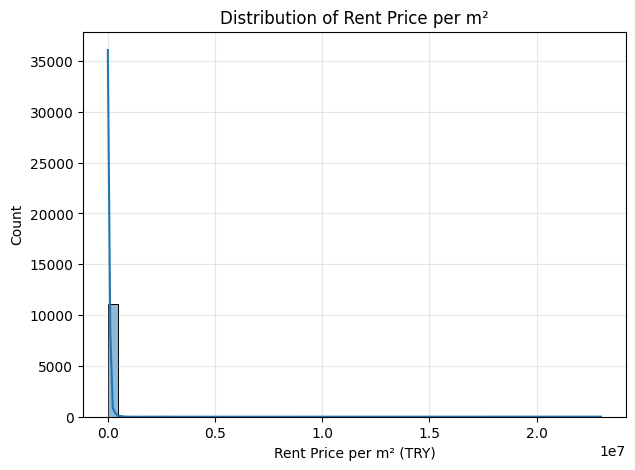

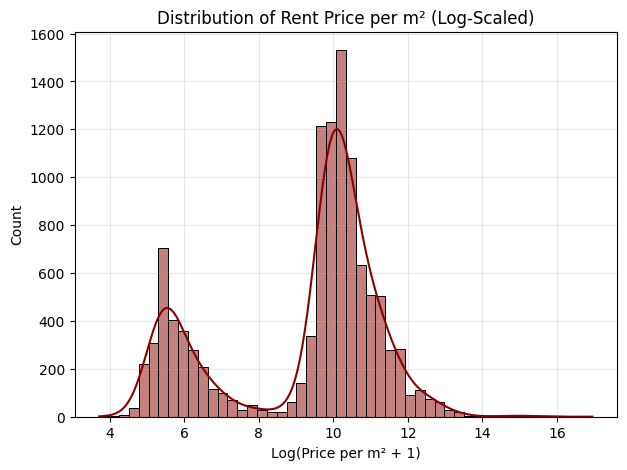

In [24]:
plt.figure(figsize=(7,5))
sns.histplot(merged_df["price_per_m2"], bins=50, kde=True)
plt.title("Distribution of Rent Price per m²")
plt.xlabel("Rent Price per m² (TRY)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# log-scale version
plt.figure(figsize=(7,5))
sns.histplot(np.log1p(merged_df["price_per_m2"]), bins=50, kde=True, color="darkred")
plt.title("Distribution of Rent Price per m² (Log-Scaled)")
plt.xlabel("Log(Price per m² + 1)")
plt.grid(True, alpha=0.3)
plt.show()

### 4.4 Distribution of Earthquake Risk Index

Risk index is normalized between 0 and 1. Most neighborhoods cluster in the 
0.05–0.2 region, indicating mild to moderate structural risk.

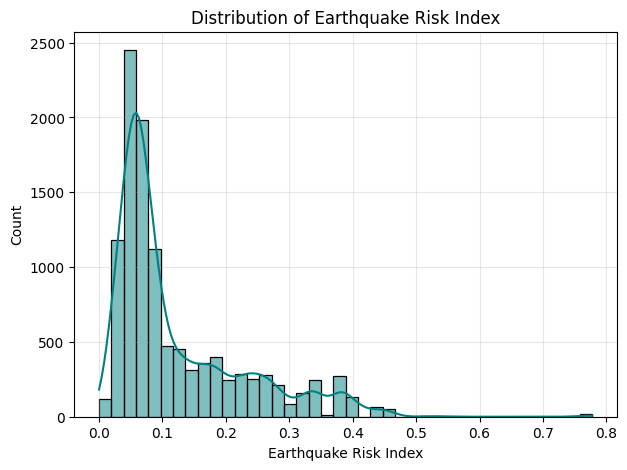

In [25]:
plt.figure(figsize=(7,5))
sns.histplot(merged_df["earthquake_risk_index"], bins=40, kde=True, color="teal")
plt.title("Distribution of Earthquake Risk Index")
plt.xlabel("Earthquake Risk Index")
plt.grid(True, alpha=0.3)
plt.show()

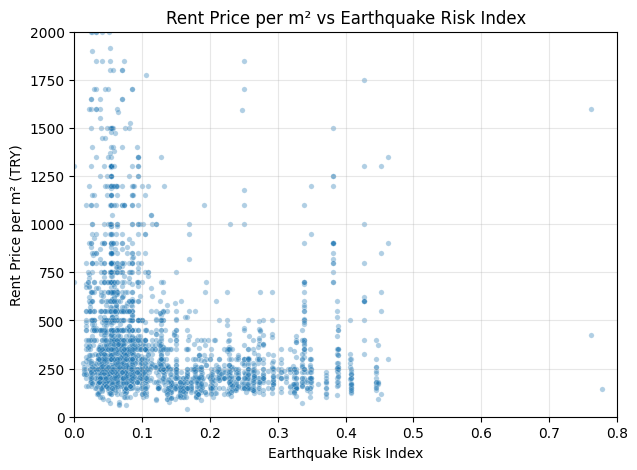

In [26]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=merged_df["earthquake_risk_index"],
    y=merged_df["price_per_m2"],
    alpha=0.35,
    s=15
)
plt.xlim(0, 0.8)
plt.ylim(0, 2000)
plt.title("Rent Price per m² vs Earthquake Risk Index")
plt.xlabel("Earthquake Risk Index")
plt.ylabel("Rent Price per m² (TRY)")
plt.grid(True, alpha=0.3)
plt.show()

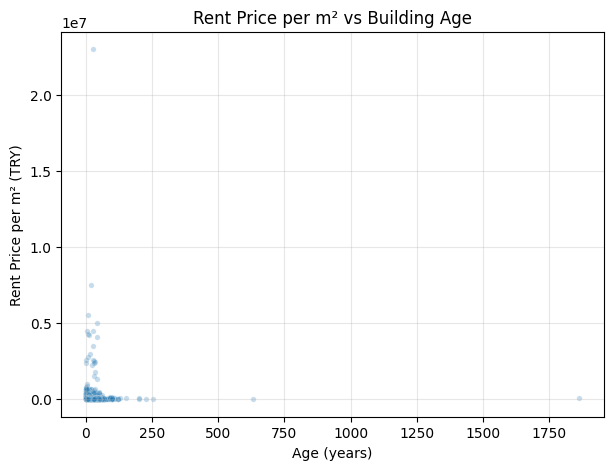

In [27]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=merged_df["age"],
    y=merged_df["price_per_m2"],
    alpha=0.25,
    s=15
)
plt.title("Rent Price per m² vs Building Age")
plt.xlabel("Age (years)")
plt.ylabel("Rent Price per m² (TRY)")
plt.grid(True, alpha=0.3)
plt.show()

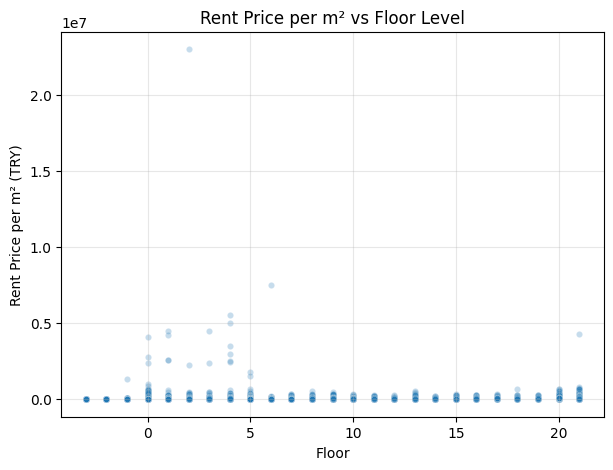

In [28]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=merged_df["floor"],
    y=merged_df["price_per_m2"],
    alpha=0.25,
    s=20
)
plt.title("Rent Price per m² vs Floor Level")
plt.xlabel("Floor")
plt.ylabel("Rent Price per m² (TRY)")
plt.grid(True, alpha=0.3)
plt.show()

### 4.6 Correlation Matrix

We examine linear relationships among structural variables, rental price, risk 
components, and combined earthquake risk index.

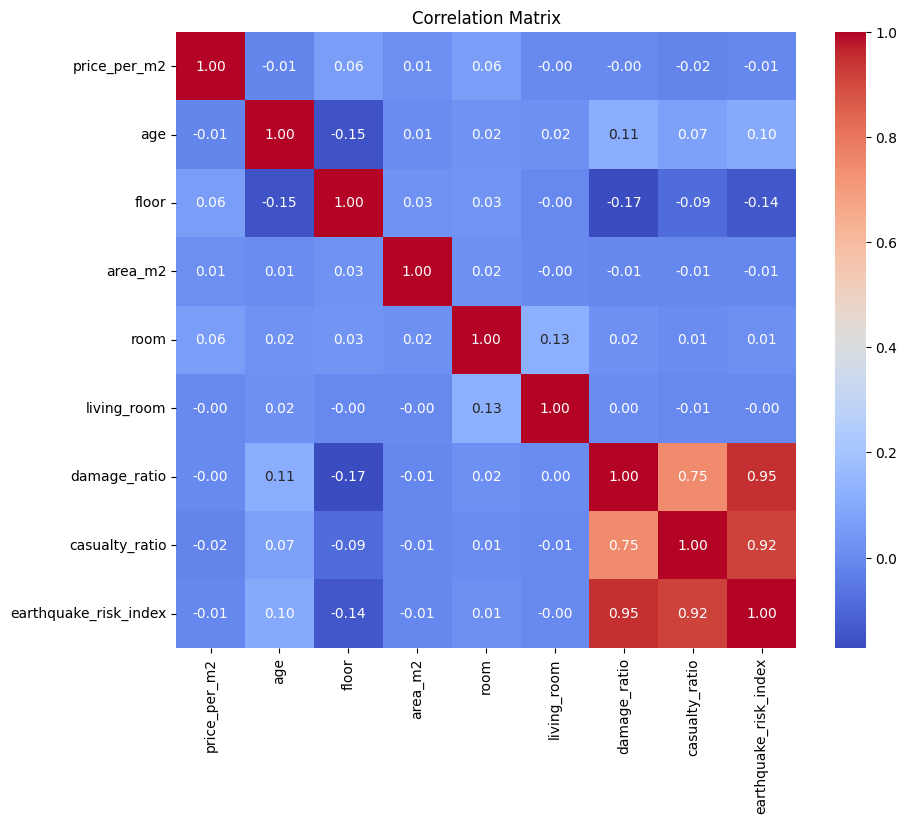

In [30]:
corr_vars = [
    "price_per_m2", "age", "floor", "area_m2", "room", "living_room",
    "damage_ratio", "casualty_ratio", "earthquake_risk_index"
]

corr_matrix = merged_df[corr_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 4.7 Creating Risk Groups

We divide neighborhoods into **High Risk** and **Low Risk** groups using the 
median earthquake risk index. This allows meaningful comparison tests later.

In [31]:
threshold = merged_df["earthquake_risk_index"].median()
merged_df["risk_group"] = np.where(
    merged_df["earthquake_risk_index"] > threshold,
    "High Risk", 
    "Low Risk"
)

merged_df["risk_group"].value_counts()

risk_group
Low Risk     5628
High Risk    5549
Name: count, dtype: int64